## Imports and utils

Open questions:
1. Could this handle multipled images?
2. Why `num_image_tokens == 576`?
3. We should make sure the input PIL images are square, or at least not super elongated such that they become distorted after resizing to 386x386
4. Is it possible to quantise this model?
5. What's the right dtype?

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [5]:
# !pip install -q bitsandbytes accelerate einops
!pip install -q einops
!pip list | grep transformers
# !pip list | grep bitsandbytes
# !pip list | grep accelerate

transformers                     4.42.4


In [1]:
import os
# from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import AutoModelForCausalLM
# from transformers import BitsAndBytesConfig
from torchvision import transforms
import torch as t
from PIL import Image
import requests
import csv
import numpy as np
import einops
from types import MethodType
from io import BytesIO

In [2]:
# !rm -rf $path_to_repo

model_id = "DeepSeek-VL"

path_to_repos = '/content/drive/MyDrive/pivotal_files/git_repos'
path_to_model = os.path.join(path_to_repos, model_id)

!mkdir -p $path_to_repos

if not os.path.exists(path_to_model):
    print(f'Cloning repo to {path_to_model}')
    os.chdir(path_to_repos)
    !git clone https://github.com/deepseek-ai/DeepSeek-VL
    os.chdir(path_to_model)
    !pwd
else:
    print(f'Repo already exists at {path_to_model}')
    os.chdir(path_to_model)

!pip install -q -e .

Repo already exists at /content/drive/MyDrive/pivotal_files/git_repos/DeepSeek-VL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for deepseek_vl (pyproject.toml) ... done


In [6]:
from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM
from deepseek_vl.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


## Load the model and tokenizer

In [7]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


In [8]:
# specify the path to the model
model_path = "deepseek-ai/deepseek-vl-1.3b-base"
model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).to(device)
model = model.to(t.bfloat16)
# model = model.to(t.float)

We want to compute the gradients only wrt to the perturbation $\delta$, not wrt the internal weights, so we switch that off here.

Note: setting the model in eval mode does not mean that gradients won't be computed.

In [9]:
model.eval();
# t.set_grad_enabled(True)
# model.train();

if model.training:
    print('Model is in training mode')
else:
    print('Model is in eval mode')

# we're only interested in computing the gradients wrt the input images, not the internal parameters
for name, param in model.named_parameters():
    param.requires_grad = False

Model is in eval mode


Define the processor so that we can pre-process the prompt+image into a format accepted by the model. This includes a normalisation step.

In [10]:
processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = processor.tokenizer

processor_mean = t.tensor(processor.image_processor.image_mean).to(device)
processor_std = t.tensor(processor.image_processor.image_std).to(device)
print(processor_mean)
print(processor_std)

img_size = processor.image_processor.image_size
print(f'img_size: {img_size}')

# Not sure why it's 576 specifically - that's the default setting in VLMImageProcessor
num_image_tokens = processor.num_image_tokens
print(f'num_image_tokens: {num_image_tokens}')

# why are these different?
# vocab_size = tokenizer.vocab_size
vocab_size = model.language_model.vocab_size

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tensor([0.5000, 0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000], device='cuda:0')
img_size: 384
num_image_tokens: 576


# Inference

## Prepare the `conversation`

Prepare the text and image prompt, using the appropriate prompt template. We select a square image and resize it to the standard size used by DeepSeep's `VLMImageProcessor`.

In [274]:
prompt = "What is shown in this image?"

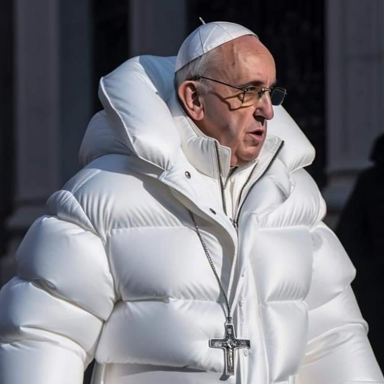

In [280]:
img_url = "https://wp.inews.co.uk/wp-content/uploads/2023/03/SEI_149780351.jpg?crop=157px%2C0px%2C1537px%2C1537px&resize=640%2C640"
img_path = '/content/sample_data/pope_swag.jpg'

def open_image_from_url(url):
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the image using PIL
        image = Image.open(BytesIO(response.content))
        return image
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")
        return None

img = open_image_from_url(img_url)
img = img.resize((img_size, img_size))
img.save(img_path)
img

In [283]:
conversation = [
    {
        "role": "User",
        "content": f"<image_placeholder>{prompt}",
        "images": [img_path]
    },
    {
        "role": "Assistant",
        "content": ""
    }
]

In [284]:
# load images and prepare for inputs
pil_image = load_pil_images(conversation) # list

Finally, use the processor to prepare the inputs to the model.
The output is a dictionary of four items:
<!-- - `input_ids` - token ids of the text prompt -->
<!-- - `attention_mask` - if processing a batch input, text prompts need to be of the same length. They are padded with 0s (by default on the right). The attention mask tells the model which tokens are legitimate and should be attended to (denoted with '1') and which ones are just for padding and should be ignored (denoted with '0'). -->
<!-- - `pixel_values` - processed images, shape: `[batch, patch, channel, height, width]`, where `patch` is because Llava is based on CLIP-ViT-L-336px and it does some weird thing with padding - even images smaller than 336x336 will be split into 3 patches of size 336x336 -->

In [286]:
prepare_inputs = processor(
    conversations=conversation,
    images=pil_image,
    force_batchify=True
).to(device)

In [287]:
prepare_inputs.input_ids;

We can understand the structure of `input_ids` by analysing the `conversation`:

In [294]:
print(dict(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids)))

{'<｜begin▁of▁sentence｜>': 100000, '<｜end▁of▁sentence｜>': 100001, '<image_placeholder>': 100015}


In [297]:
print(prepare_inputs.sft_format)
print(prepare_inputs.input_ids.shape)
print(prepare_inputs.pixel_values.shape)
print(prepare_inputs.attention_mask.shape)
print(prepare_inputs.images_seq_mask.shape)
print(prepare_inputs.images_emb_mask.shape)

['You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\nUser: <image_placeholder>What is shown in this image?\n\nAssistant:']
torch.Size([1, 628])
torch.Size([1, 1, 3, 384, 384])
torch.Size([1, 628])
torch.Size([1, 628])
torch.Size([1, 1, 576])


In [300]:
# this format is not appropriate, as it includes whitespaces at linebreaks
# SYSTEM_PROMPT = """You are a helpful language and vision assistant.
#                    You are able to understand the visual content that the user provides,
#                    and assist the user with a variety of tasks using natural language."""

SYSTEM_PROMPT = (
        "You are a helpful language and vision assistant. "
        "You are able to understand the visual content that the user provides, "
        "and assist the user with a variety of tasks using natural language."
    )

In [387]:
bos_tokenized = t.tensor([tokenizer.bos_token_id]).to(device).unsqueeze(0)
print(bos_tokenized)
system_prompt_tokenized = tokenizer.encode(SYSTEM_PROMPT, add_special_tokens=False, return_tensors='pt').to(device)
print(system_prompt_tokenized)
user_tokenized = tokenizer.encode('\n\nUser: ', add_special_tokens=False, return_tensors='pt').to(device)
print(user_tokenized)
prompt_tokenized = tokenizer.encode(prompt, add_special_tokens=False, return_tensors='pt').to(device)
print(prompt_tokenized)
assistant_tokenized = tokenizer.encode('\n\nAssistant:', add_special_tokens=False, return_tensors='pt').to(device)
print(assistant_tokenized)

image_token = tokenizer.encode('<image_placeholder>', add_special_tokens=False, return_tensors='pt').to(device)
print(image_token)

input_ids = t.cat((bos_tokenized , system_prompt_tokenized , user_tokenized , image_token.repeat((1, num_image_tokens)), prompt_tokenized , assistant_tokenized), axis=1).to(device)
assert t.equal(input_ids, prepare_inputs['input_ids'])

tensor([[100000]], device='cuda:0')
tensor([[ 2054,   418,   245,  9394,  4706,   285, 10046, 20308,    13,  1257,
           418,  2249,   276,  2579,   254,  7959,  3093,   344,   254,  2677,
          4614,    11,   285,  4750,   254,  2677,   366,   245,  6265,   280,
          9224,  1244,  3892,  4706,    13]], device='cuda:0')
tensor([[ 185,  185, 5726,   25,  207]], device='cuda:0')
tensor([[2640,  317, 3707,  279,  437, 3324,   30]], device='cuda:0')
tensor([[  185,   185, 77398,    25]], device='cuda:0')
tensor([[100015]], device='cuda:0')


Now try to pre-process the images in the same way. The relevant code is in `deepseek_vl/models/image_processing_vlm.py`. There are three steps in the VLMImageProcessor class:
1. `resize` - this function:
- checks if the input images don't have some stupid dimensions like $(1, 1000)$ or $(0, 100)$
- resizes the image to a specified size ($(384, 384)$ in the case of DeepSeek)
- turns a rectangular image into a square by padding the remaining region with a predefined background colour.

    We will assume that all images are square, so this function only performs the resizing.

2. `rescale` - this just multiplies by $1.0/255.0$ to convert to $[0.0, 1.0]$ range
3. `normalise` - `VLMImageProcessor` has some default $(\mu, \sigma)$, but these are overwritten by the `.from_pretrained()` parameters

In [388]:
# @title Understanding `VLMImageProcessor.resize()`

# copier from image_processing_vlm.py
def resize(self, pil_img: Image) -> np.ndarray:
        """

        Args:
            pil_img (PIL.Image): [H, W, 3] in PIL.Image in RGB

        Returns:
            x (np.ndarray): [3, self.image_size, self.image_size]
        """
        # JK: Here they're just checking if the image sizes are not extremely weird
        width, height = pil_img.size
        max_size = max(width, height)

        size = [
            max(int(height / max_size * self.image_size), self.min_size),
            max(int(width / max_size * self.image_size), self.min_size),
        ]

        if width <= 0 or height <= 0 or size[0] <= 0 or size[1] <= 0:
            print(f"orig size = {pil_img.size}, new size = {size}")
            raise ValueError("Invalid size!")

        # JK: so only this is important.Simple rescaling with bicubic interpolation
        pil_img = torchvision.transforms.functional.resize(
            pil_img,
            size,
            interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC,
            antialias=True,
        )

        # JK: this just makes the image into a square by filling the missing space with a predefined background colour
        pil_img = expand2square(pil_img, self.background_color)
        x = to_numpy_array(pil_img)

        # JK: transpose to put the colour first (why not use einops??)
        # [H, W, 3] -> [3, H, W]
        x = np.transpose(x, (2, 0, 1))

        return x



Weird: the vision processor has the normalisation switched off by default - is it done somewhere else? (I don't think so)

In [389]:
processor.image_processor.do_normalize

False

In [390]:
# this assumes the images are squares to begin with
prep = transforms.Compose([
    # we skip the rescaling from 255->1 here because we will already start with a Tensor in this range
    transforms.Resize(size=(img_size, img_size), interpolation=transforms.functional.InterpolationMode.BICUBIC, antialias=True),
    # transforms.Normalize(mean=processor_mean, std=processor_std)
])

In [391]:
# this is the starting tensor - we will optimise it
init_image = transforms.ToTensor()(pil_image[0]).to(t.bfloat16).to(device).requires_grad_(True)

# the t.clamp here is unnecessary if working with just the original image
# but will become necessary once we start adding + eps*delta to it
tensor_image = t.clamp(prep(init_image), 0, 1).unsqueeze(0).unsqueeze(0)
tensor_image.shape

torch.Size([1, 1, 3, 384, 384])

In [392]:
t.equal(prepare_inputs.pixel_values, tensor_image)

True

In [393]:
# @title Verifying that the pre-processing now doesn't break the gradients { vertical-output: true, display-mode: "both" }

# use some very dumb loss function just to check that gradients propagate

init_image_test = transforms.ToTensor()(pil_image[0]).to(device).requires_grad_(True)
optimiser = t.optim.Adam([init_image_test], lr=1e-2)

for step in range(5):
    print(f'step: {step}')
    tensor_image_test = t.clamp(prep(init_image_test), 0, 1).unsqueeze(0)
    loss = -t.log(tensor_image_test.mean())
    print(loss)
    loss.backward()
    # print(init_image.grad)
    optimiser.step()
    optimiser.zero_grad()

step: 0
tensor(0.7178, device='cuda:0', grad_fn=<NegBackward0>)
step: 1
tensor(0.6976, device='cuda:0', grad_fn=<NegBackward0>)
step: 2
tensor(0.6777, device='cuda:0', grad_fn=<NegBackward0>)
step: 3
tensor(0.6583, device='cuda:0', grad_fn=<NegBackward0>)
step: 4
tensor(0.6393, device='cuda:0', grad_fn=<NegBackward0>)


## `inputs_embeds` - concatenation of embeddings

In [405]:
print(prepare_inputs.keys())
# not sure why the attention mask is all 1s - shouldn't it contain 0s at some point?
attention_mask = t.ones(prepare_inputs['input_ids'].shape, dtype=t.long).to(device)
assert t.equal(attention_mask, prepare_inputs['attention_mask'])

image_token_mask: t.BoolTensor = prepare_inputs.input_ids == image_token
image_indices = image_token_mask.nonzero()

image_seq_mask = image_token_mask # boolean mask [n_batches, n_tokens]
assert t.equal(image_seq_mask, prepare_inputs['images_seq_mask'])

image_emb_mask = t.ones(num_image_tokens, dtype=t.bool).unsqueeze(0).unsqueeze(0).to(device) # [n_batches, n_images, n_image_tokens]?
assert t.equal(image_emb_mask, prepare_inputs['images_emb_mask'])

dict_keys(['sft_format', 'input_ids', 'pixel_values', 'attention_mask', 'images_seq_mask', 'images_emb_mask'])


Similarly to above, we will try to understand the structure of `inputs_embeds`.


In [406]:
inputs_embeds = model.prepare_inputs_embeds(**prepare_inputs)
inputs_embeds.shape

torch.Size([1, 628, 2048])

In [407]:
hidden_size = model.config.language_config.hidden_size # 2048

In [408]:
image_seq_mask;
bos_embedded = model.language_model.get_input_embeddings()(bos_tokenized)
system_prompt_embedded = model.language_model.get_input_embeddings()(system_prompt_tokenized)
user_embedded = model.language_model.get_input_embeddings()(user_tokenized)
prompt_embedded = model.language_model.get_input_embeddings()(prompt_tokenized)
assistant_embedded = model.language_model.get_input_embeddings()(assistant_tokenized)

# the einops lines are only necessary if there's more than one batch or image per batch
n_batches, n_images = tensor_image.shape[0:2]
images = einops.rearrange(tensor_image, "b n c h w -> (b n) c h w")
image_embedded = model.aligner(model.vision_model(images))
image_embedded = einops.rearrange(image_embedded, "(b n) t d -> b (n t) d", b=n_batches, n=n_images)

input_embedded = t.cat((bos_embedded , system_prompt_embedded , user_embedded , image_embedded, prompt_embedded , assistant_embedded), axis=1).to(device)
assert t.equal(input_embedded, inputs_embeds)

In [ ]:
# url = "https://github.com/haotian-liu/LLaVA/blob/3a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"

# delta = t.zeros_like(image_tensor[0], requires_grad=True, device=device)

# # l-\infty norm
# eps = 8/255

# perturbed_image_tensor = [(img_tensor + eps * delta.clamp(-1, 1)).clamp(0, 1).to(device) for img_tensor in image_tensor]

Now define the target token which we want to force the model to predict using the adversarial perturbation.

In [420]:
# Trump token - chosen arbitrarily
# print(tokenizer.encode('Trump'))
# tokenizer.decode(27504)

target = ["Trump"]
target_tokenized = [tokenizer.encode(t) for t in target]
target_tokenized = t.tensor(target_tokenized).to(device)

In [ ]:
# use this to display the processed image that has been split into patches:
# display_processed_tiles(inputs.pixel_values.clone().detach());

Now, finally do the forward pass:

In [418]:
output_original = model.language_model.forward(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    use_cache=True,
    return_dict=True
)

output = model.language_model.forward(
    inputs_embeds=input_embedded,
    attention_mask=attention_mask,
    use_cache=True,
    return_dict=True
)

assert t.equal(output_original.logits, output.logits)

In [ ]:
# answer = tokenizer.decode(output[0].cpu().tolist(), skip_special_tokens=True)
# print(f"{prepare_inputs['sft_format'][0]}", answer)

In [421]:
logits = output.logits # [batch, sequence_position, vocab]
next_token_logits = logits[:, -1] # [batch, vocab]
print(next_token_logits.shape)
next_token_pred = tokenizer.batch_decode(next_token_logits.argmax(-1), skip_special_tokens=True)
print(next_token_pred)
loss_fn = t.nn.CrossEntropyLoss()
loss_fn.requires_grad = True # not sure why I need to include this line
loss = loss_fn(next_token_logits, target_tokenized[:, -1])
# loss.requires_grad=True
print(loss)
model.zero_grad()
loss.backward()

torch.Size([1, 102400])
['\n']
tensor(15.4073, device='cuda:0', grad_fn=<NllLossBackward0>)


In [423]:
init_image.grad.data.shape

torch.Size([3, 384, 384])